In [1]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from transformers import AlbertTokenizer, AlbertModel,AlbertConfig

from PIL import Image
import requests

from typing import Dict, List, Optional, Set, Tuple, Union
import torch.utils.checkpoint
from torch import nn
import math

In [3]:
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertModel.from_pretrained("albert-base-v2",output_hidden_states = True)
text = "Glial cells account for between 50% to 90% of all human brain cells, and serve a variety of important developmental, structural, and metabolic functions. Recent experimental efforts suggest that astrocytes, a type of glial cell, are also directly involved in core cognitive processes such as learning and memory. While it is well-established that astrocytes and neurons are connected to one another in feedback loops across many time scales and spatial scales, there is a gap in understanding the computational role of neuron-astrocyte interactions. To help bridge this gap, we draw on recent advances in artificial intelligence (AI) and astrocyte imaging technology. In particular, we show that neuron-astrocyte networks can naturally perform the core computation of a Transformer, a particularly successful type of AI architecture. In doing so, we provide a concrete and experimentally testable account of neuron-astrocyte communication. Because Transformers are so successful"
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.dense.bias', 'predictions.bias', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
token_number = 195
tokenizer.decode(encoded_input['input_ids'][0][token_number])

'successful'

In [5]:
import transformers
from transformers.pytorch_utils import find_pruneable_heads_and_indices, prune_linear_layer,apply_chunking_to_forward
from transformers.activations import ACT2FN


class AlbertAttention(nn.Module):
    def __init__(self, config: AlbertConfig):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads}"
            )

        self.num_attention_heads = config.num_attention_heads
        self.hidden_size = config.hidden_size
        self.attention_head_size = config.hidden_size // config.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.attention_dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.output_dropout = nn.Dropout(config.hidden_dropout_prob)
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.pruned_heads = set()

        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

    # Copied from transformers.models.bert.modeling_bert.BertSelfAttention.transpose_for_scores
    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def prune_heads(self, heads: List[int]) -> None:
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.num_attention_heads, self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.query = prune_linear_layer(self.query, index)
        self.key = prune_linear_layer(self.key, index)
        self.value = prune_linear_layer(self.value, index)
        self.dense = prune_linear_layer(self.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.num_attention_heads = self.num_attention_heads - len(heads)
        self.all_head_size = self.attention_head_size * self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: bool = False,
    ) -> Union[Tuple[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]:
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.attention_dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.transpose(2, 1).flatten(2)

        projected_context_layer = self.dense(context_layer)
        projected_context_layer_dropout = self.output_dropout(projected_context_layer)
        layernormed_context_layer = self.LayerNorm(hidden_states + projected_context_layer_dropout)
        return (layernormed_context_layer, attention_probs) if output_attentions else (layernormed_context_layer,),attention_scores,attention_probs,query_layer,key_layer


class AlbertLayer(nn.Module):
    def __init__(self, config: AlbertConfig):
        super().__init__()

        self.config = config
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.full_layer_layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.attention = AlbertAttention(config)
        self.ffn = nn.Linear(config.hidden_size, config.intermediate_size)
        self.ffn_output = nn.Linear(config.intermediate_size, config.hidden_size)
        self.activation = ACT2FN[config.hidden_act]
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: bool = False,
        output_hidden_states: bool = False,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        attention_output,attention_scores,attention_probs,query_layer,key_layer = self.attention(hidden_states, attention_mask, head_mask, output_attentions)

        ffn_output = apply_chunking_to_forward(
            self.ff_chunk,
            self.chunk_size_feed_forward,
            self.seq_len_dim,
            attention_output[0],
        )
        hidden_states = self.full_layer_layer_norm(ffn_output + attention_output[0])

        return (hidden_states,) + attention_output[1:],attention_scores,attention_probs,query_layer,key_layer  # add attentions if we output them

    def ff_chunk(self, attention_output: torch.Tensor) -> torch.Tensor:
        ffn_output = self.ffn(attention_output)
        ffn_output = self.activation(ffn_output)
        ffn_output = self.ffn_output(ffn_output)
        return ffn_output


In [6]:
#get block of pretrained ALBERT
layer_num = 1
#pick an attention head
nhead = 5
#block of pretrained ALBERT
albert_block = model.encoder.albert_layer_groups[0].albert_layers[0]

#instantiate custom attention
custom_self_attn = AlbertAttention(config = model.config)
custom_self_attn.key = albert_block.attention.key
custom_self_attn.value = albert_block.attention.value
custom_self_attn.query = albert_block.attention.query
custom_self_attn.attention_dropout = albert_block.attention.attention_dropout
custom_self_attn.output_dropout = albert_block.attention.output_dropout
custom_self_attn.dense = albert_block.attention.dense



#instantiate custom layer
custom_layer = AlbertLayer(config = model.config)
custom_layer.attention = custom_self_attn
custom_layer.ffn = albert_block.ffn
custom_layer.ffn_output = albert_block.ffn_output


outputs_of_previous_layer = output['hidden_states'][layer_num-1]
custom_outputs,attention_scores,attention_probs,query_layer,key_layer = custom_layer(outputs_of_previous_layer)
#custom_outputs = custom_layer(outputs_of_previous_layer)





'''

#pass in outputs of previous layer
outputs_of_previous_layer = outputs['hidden_states'][layer_num-1]
custom_outputs,attention_scores,attention_probs,query_layer,key_layer = custom_layer(outputs_of_previous_layer)
'''
#normalize Q and K matrices appropriately 
query_layer /= custom_self_attn.attention_head_size**(1/4)
key_layer /= custom_self_attn.attention_head_size**(1/4)

query_layer = query_layer.detach().numpy()
key_layer = key_layer.detach().numpy()



In [7]:
rand_seed = 16

np.random.seed(rand_seed) #for reproducibility

def get_phi(m,D,which_phi = 'performer'):
  
  '''Function that returns the random feature map, phi. 
  Since our neuron-astrocyte model is equivalent to using Random Feature Attention, we use this representation for simplicity. 
  Different phi functions lead to different feature maps.'''

  #random weight matrix for random feature map
  W = np.random.normal(0,1,(m,D))

  if which_phi == 'cosine':
    #random biases for cosine feature map
    rand_b = np.random.uniform(0,2*np.pi,m)

    def phi(x,c = 0):
      '''Uses an cosine  random feature map to approximate softmax attention.'''
      return np.sqrt(2/m)*np.cos(W @ x + rand_b)*np.exp(0.5*(np.linalg.norm(x)**2) - c)


  if which_phi == 'performer':
    def phi(x,c = 0):
      '''Uses an exponential random feature map to approximate softmax attention.'''
      #x has dimensions of the encoded tokens (for albert this is m = 768)
      return np.exp( -0.5*np.log(m) + W @ x - 0.5*(np.linalg.norm(x)**2))

  if which_phi == 'linear':
    def phi(x,c = 0):
      '''Uses an exponential random feature map to approximate softmax attention.'''
      #x has dimensions of the encoded tokens (for albert this is m = 768)
      h =  -0.5*np.log(m) + W @ x - 0.5*(np.linalg.norm(x)**2)
      return 1 + h

  if which_phi == 'truncated_performer':
    def phi(x,thresh = 150):
      '''Uses an exponential random feature map to approximate softmax attention.'''
      #x has dimensions of the encoded tokens (for albert this is m = 768)
      scaling_factors = np.exp( -0.5*np.log(m) - 0.5*(np.linalg.norm(x)**2))
      h = np.exp(W @ x)
      return scaling_factors*np.maximum(0,np.minimum(h,thresh))

  if which_phi == 'positive_cosine':
    #random biases for cosine feature map
    rand_b = np.random.uniform(0,2*np.pi,m)
    def phi(x,thresh = 10):
      '''Uses an exponential random feature map to approximate softmax attention.'''
      #x has dimensions of the encoded tokens (for albert this is m = 768)
      scaling_factors = np.sqrt(2/(np.pi*m))*np.exp(0.5*(np.linalg.norm(x)**2))
      h = np.cos(W @ x + rand_b)
      return np.maximum(0,scaling_factors*h)

  if which_phi == 'dima_sin':
    #random biases for cosine feature map
    rand_b = np.random.uniform(0,2*np.pi,m)

    def clipped_sin(x):      
      if -np.pi/2 < x < np.pi/2:
        y = np.sin(x)
      if x > np.pi/2:
        y = 1
      if x < -np.pi/2:
        y = -1

      return y

    v_clipped_sin = np.vectorize(clipped_sin)       


    def phi(x,thresh = 10):
      '''Uses an exponential random feature map to approximate softmax attention.'''
      #x has dimensions of the encoded tokens (for albert this is m = 768)
      scaling_factors = np.sqrt(2/m)*np.exp(0.5*(np.linalg.norm(x)**2))
      h = v_clipped_sin(W @ x + rand_b)
      return scaling_factors*h #np.maximum(0,scaling_factors*h)

  return phi

In [8]:

def get_astro_responses(query_layer,key_layer,nhead,phi):
  '''Computes astrocyte response given a random feature map, queries, and keys.'''

  ntokens = query_layer.shape[2]

  rfa_key_sum = 0
  for i in range(ntokens):  
    rfa_normalized_keys = phi(key_layer[0,nhead,i,:])
    rfa_key_sum += rfa_normalized_keys

  astro_ps = np.zeros(ntokens)

  for t in range(ntokens):
    q_t = query_layer[0,nhead,t]
    astro_ps[t] = np.dot(phi(q_t),rfa_key_sum)

  return astro_ps

#Constructing phi (random features)

phi_low_m = get_phi(m = int(1e3), D = custom_self_attn.attention_head_size,which_phi = 'performer') 
phi_high_m = get_phi(m = int(1e5), D = custom_self_attn.attention_head_size,which_phi = 'performer') 

astro_ps_low_m = get_astro_responses(query_layer,key_layer,nhead,phi_low_m)
astro_ps_high_m = get_astro_responses(query_layer,key_layer,nhead,phi_high_m)

attention_normalizations = torch.exp(attention_scores[0,nhead]).sum(-1).detach().numpy()


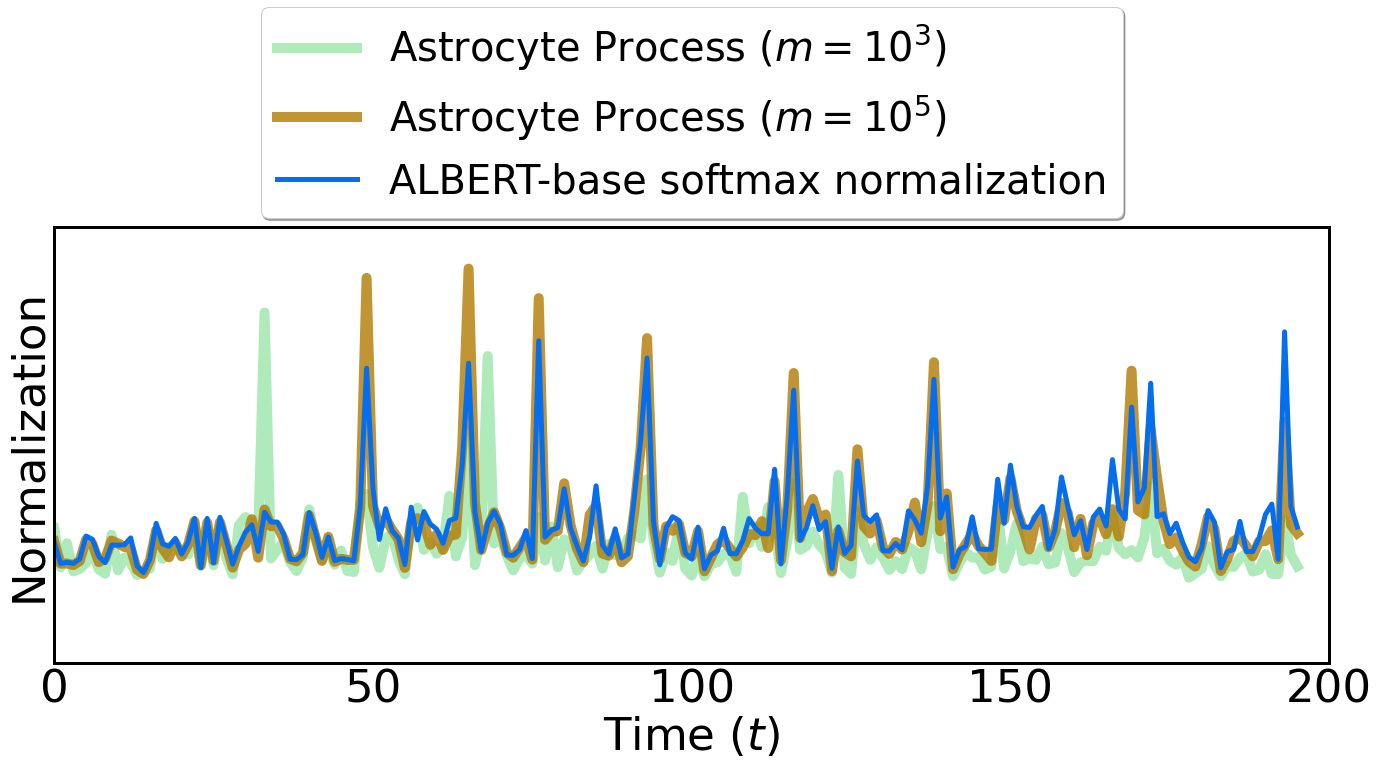

In [10]:
#plot astrocyte process state against "true" ViT normalization values

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3
plt.grid(False)
fs = 45

t_to_plot_until = 196


plt.plot(astro_ps_low_m[:t_to_plot_until],color = '#9be5aa',linewidth = 10,alpha = 0.8,label = r'Astrocyte Process ($m = 10^3$)')#,linestyle = 'dotted')
plt.plot(astro_ps_high_m[:t_to_plot_until],color = '#b27a01',linewidth = 10,alpha = 0.8,label = r'Astrocyte Process ($m = 10^5$)')
plt.plot(attention_normalizations[:t_to_plot_until],color = '#056eee',linewidth = 5,label = r'ALBERT-base softmax normalization')
plt.tight_layout()
plt.legend(fontsize = 40,loc='upper center',shadow = True, bbox_to_anchor=(0.5, 1.55),fancybox = True)


plt.tick_params(length = 1,width = 2)
fig = plt.gcf()
fig.set_size_inches(20, 7)
plt.yticks([])
plt.xticks(np.arange(0,250,50),np.arange(0,250,50),fontsize=fs)
plt.xlabel('Time ($t$)',fontsize = fs)
plt.ylabel('Normalization',fontsize = fs)

y_lim_slack = 120
plt.ylim(np.min(astro_ps_low_m)-y_lim_slack,np.max(astro_ps_low_m)+y_lim_slack)

plt.xlim(0,200)

#plt.savefig('ALBERT_softmax.png',dpi = 300,bbox_inches='tight')
